# Moving Barrier 1: One stationary and one moving wall

This experiment is partially successful. When we generate moving barriers from the base maze, we gradually add a number (`Hstep`) to an expanding region (See the following code for details). If you generate moving barriers with high `Hstep` (such as 1) when we use `fill_region`, the solution **diverges**. In the following we use a successful parameter `Hstep = 0.01`.

## Set up (define distributions & base walls)

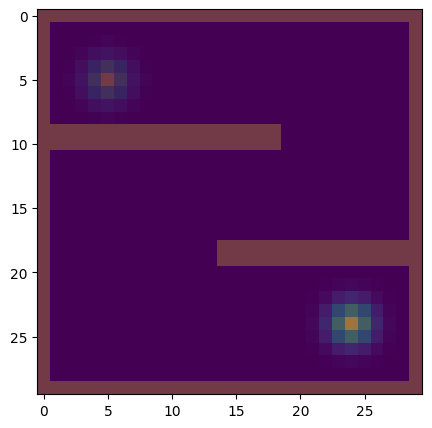

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact
from PIL import Image

def image_to_numpy(image_path):
    # Load the image file
    image = Image.open(image_path).convert('L')  # Convert image to grayscale if it's not

    # Convert the PIL image to a numpy array
    image_array = np.array(image)

    return image_array

maze = (1-image_to_numpy('data/input/maze.png').squeeze()/255)

T = 30
N1 = maze.shape[0]
N2 = maze.shape[1]

H = np.repeat(maze[np.newaxis, :, :], T, axis=0)
F = np.zeros((T,))

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 5./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 24./30.], cov=2./36**2)

plt.figure(figsize=(5, 5))
plt.imshow(maze)
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()  

## Set up of the moving barrier

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def fill_region(frames, fps, speed, original, Hstep):
    rows, cols = 30, 30
    step_size = speed*14/fps

    # Define the region to fill
    start_col, end_col = 1, 14

    # Create a list to store each frame
    filled_frames = [original]

    for i in range(1,frames):
        frame = filled_frames[-1].copy()
        # Determine the slice to fill based on speed
        end_fill = max(1, int(end_col - i*step_size))
        frame[18:20, end_fill:14] += Hstep
        # if above 1, clip to 1
        frame[frame > 1] = 1
        
        # Append the current state of the array to the list
        filled_frames.append(frame.copy())
    
    return filled_frames

def plot_frames(frames):
    fig, axes = plt.subplots(1, len(frames), figsize=(15, 5))
    for idx, frame in enumerate(frames):
        ax = axes[idx]
        ax.imshow(frame, cmap='viridis', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f'Frame {idx + 1}')
    plt.tight_layout()
    plt.show()


# Generate frames
frames = fill_region(T, 30, 10.0, maze, Hstep=1.0)

H = np.stack(frames, axis=0)

# Plot frames
#for i in range(T):
#    plt.imshow(H[i])
#    plt.show()

## Calculation of the geodesic
We note that the value of delta is increased from the default 1.0 to 10.0.
This is because we do not want teleportation through the wall.

In [66]:
from collections import defaultdict
ll=(1.0, 1.0, 1.0)
log = defaultdict(list)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=10.0, niter=50000, big_matrix=True) #alpha = 0.018, gamma = max(rho_0.max(), rho_1.max())/15)

## Plot of the geodesic

In [67]:
def plot_maze_2(t, x, H, xx, yy, rho_0, rho_1, ismask=False):
    f, axes = plt.subplots(1, 3, figsize=[10, 5])
    ax1, ax2, ax3 = axes
    if t <= 0:
        ax1.imshow(H[0] > 0)
        ax1.imshow(rho_0, alpha=0.5)
        ims2 = ax2.imshow(x.V.Z[0], vmin=-40, vmax=40)
        f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][0], x.V.D[1][0], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    elif t >= T:
        ax1.imshow(H[T-1] > 0)
        ax1.imshow(rho_1, alpha=0.5)
        ims2 = ax2.imshow(x.V.Z[T-1], vmin=-5, vmax=5)
        f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][T-1], x.V.D[1][T-1], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    else:
        masked1 = np.ma.masked_where(np.abs(x.V.D[0][t]) < 1e-3, x.V.D[0][t])
        if ismask:
            ax1.imshow(masked1)
        else:
            ax1.imshow(H[t] > 0)
            ax1.imshow(x.V.D[0][t], alpha=0.5)
        masked = np.ma.masked_where(np.abs(x.V.Z[t]) < 1e-3, x.V.Z[t])
        cmap = plt.cm.viridis
        cmap.set_bad(color='white')
        ims2 = ax2.imshow(masked, vmin=-5, vmax=5)
        f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][t], x.V.D[1][t], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

plot_elements9 = [x.copy(), H.copy(), xx, yy, rho_0.copy(), rho_1.copy(), False]
interact(lambda t: plot_maze_2(t, *plot_elements9), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=30), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

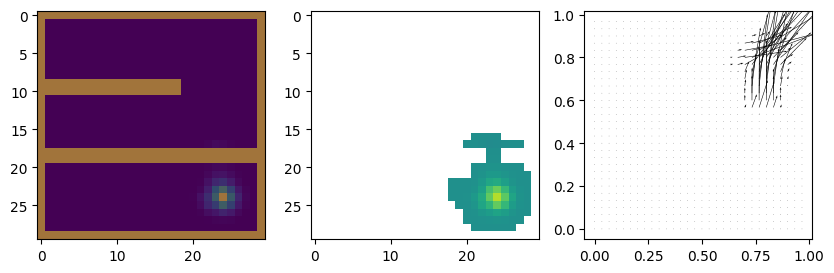

In [68]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, axes = plt.subplots(1, 3, figsize=[10, 5])
ax1, ax2, ax3 = axes

# Make global references to your images/quivers so you can update them
im1 = ax1.imshow(np.zeros((10,10)), animated=True)  # placeholders
im2 = ax2.imshow(np.zeros((10,10)), vmin=-5, vmax=5, animated=True)
quiv = ax3.quiver([], [], [], [], cmap="gray_r")

def init():
    # Any static initialization
    ax3.set_aspect('equal', adjustable='box')
    ax3.invert_yaxis()
    return (im1, im2, quiv)

def update(t):
    # Clear or update each axis, or just update data in the existing artists
    ax1.clear()
    ax2.clear()
    ax3.clear()

    # Possibly replicate logic from plot_maze_2, but do not create new figures.
    # For example:
    ax1.imshow(H[t] > 0)
    ax1.imshow(x.V.D[0][t], alpha=0.5)
    masked = np.ma.masked_where(np.abs(x.V.Z[t]) < 1e-3, x.V.Z[t])
    im2 = ax2.imshow(masked, vmin=-5, vmax=5, animated=True)
    quiv = ax3.quiver(xx, yy, x.V.D[2][t], x.V.D[1][t], cmap="gray_r")
    ax3.invert_yaxis()
    ax3.set_aspect('equal', adjustable='box')

    return (im1, im2, quiv)

ani = FuncAnimation(fig, update, frames=range(T),
                    init_func=init, blit=False)

ani.save("data/output/one_stationary_one_moving_speed10_50000iters.mp4", fps=10)

## Violation of the constraint and convergence plots

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\i'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\i'
C:\Users\mao17\AppData\Local\Temp\ipykernel_27484\1544966775.py:17: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$\sum_{t}|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each iteration")
C:\Users\mao17\AppData\Local\Temp\ipykernel_27484\1544966775.py:21: SyntaxWarning: invalid escape sequence '\i'
  plt.title("$|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each t for the final solution")


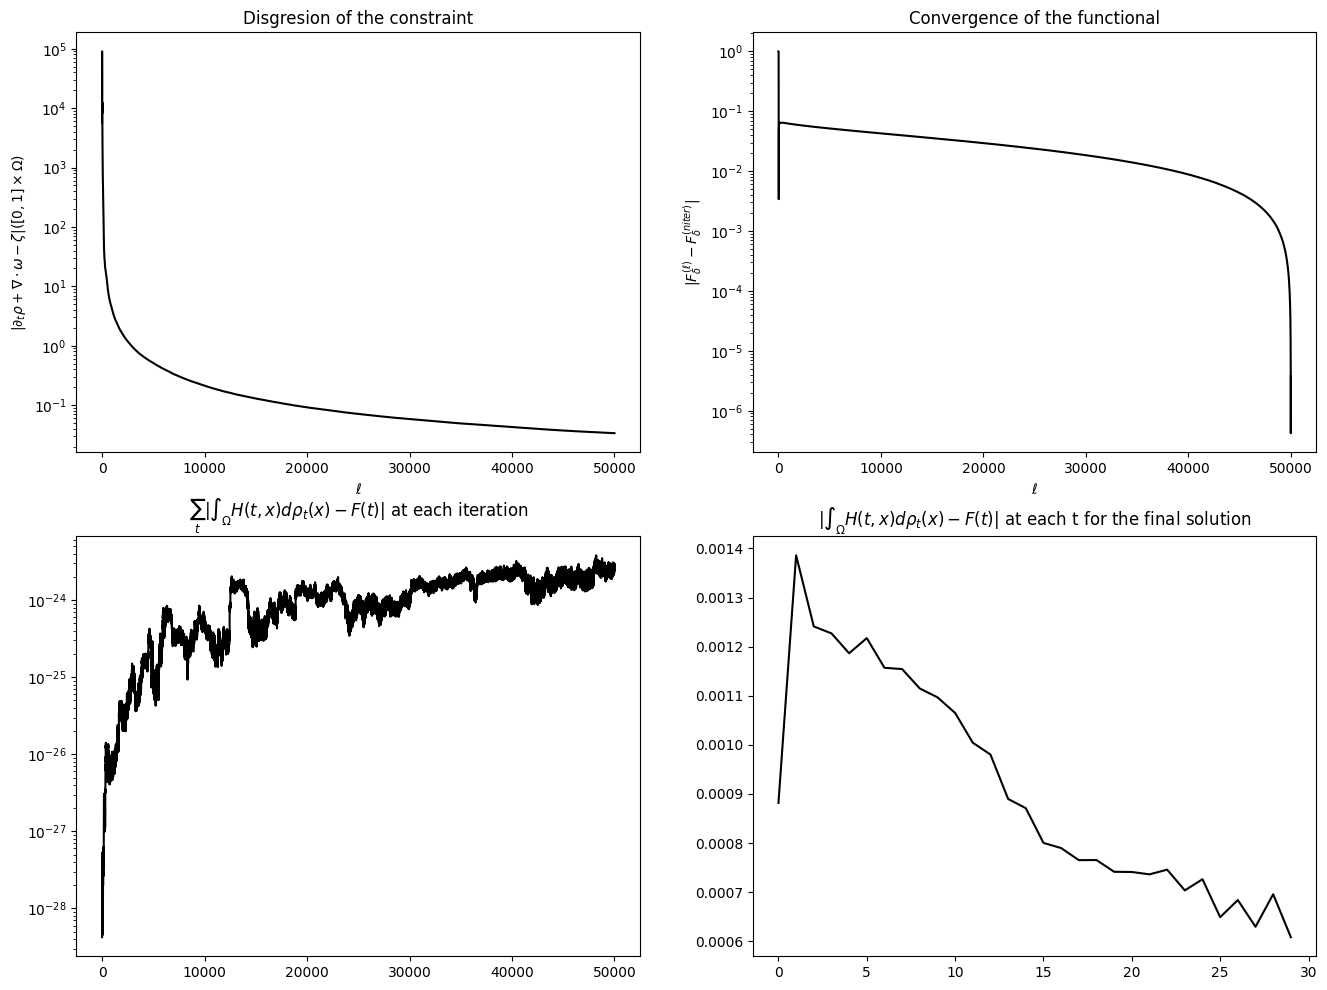

In [69]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.ylabel(r"$|\partial_t \rho + \nabla \cdot \omega - \zeta|([0,1]\times \Omega)$")
plt.xlabel(r"$\ell$")
plt.title("Disgresion of the constraint")
plt.semilogy(lists[1], "k")

plt.subplot(2, 2, 2)
plt.ylabel(r"$|F_{\delta}^{(\ell)}-F_{\delta}^{(niter)}|$")
plt.xlabel(r"$\ell$")
plt.title("Convergence of the functional")
minF = np.min(lists[0][-10:])
plt.semilogy(np.minimum(1, np.abs(lists[0] - np.mean(lists[0][-10:]))), "k")

plt.subplot(2, 2, 3)
plt.title("$\sum_{t}|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each iteration")
plt.semilogy(lists[2], "k")

plt.subplot(2, 2, 4)
plt.title("$|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each t for the final solution")
plt.plot(np.abs(np.sum(x.V.D[0]*H, axis=(1,2))*1./900.-F), "k")

plt.show()

